<a href="https://colab.research.google.com/github/rosy137/lab-python/blob/main/ml02_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports
* import module_name [as nickname]
* from module_name import class_name, function_name, ...


In [198]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn 패키지: 머신 러닝 알고리즘을 구현한 패키지.
from sklearn.neighbors import KNeighborsClassifier # class
from sklearn.model_selection import train_test_split # function

# 분류 평가 지표 함수들
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# 스케일러
from sklearn.preprocessing import StandardScaler

#데이터셋 준비
수산시장(fish market) 데이터 셋. 물고기 종류(어종)과 물고기의 여러가지 특성들(길이, 무게, 대각선 길이, ...)이 정리된 CSV 파일.

In [129]:
# CSV 파일 경로
fish_csv = 'https://raw.githubusercontent.com/JakeOh/20230228_itwill_java140_lab_python/main/fish.csv'

In [130]:
# CSV 파일을 읽어서 DataFrame을 생성
fish_df = pd.read_csv(fish_csv)

In [131]:
fish_df.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [132]:
fish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   159 non-null    object 
 1   Weight    159 non-null    float64
 2   Length    159 non-null    float64
 3   Diagonal  159 non-null    float64
 4   Height    159 non-null    float64
 5   Width     159 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.6+ KB


# 데이터 탐색(EDA: Exploratory Data Analysis)

## 카테고리 타입 변수 탐색

In [133]:
fish_df.Species.unique() # 중복되지 않는 값

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

In [134]:
spcies_count = fish_df.Species.value_counts()

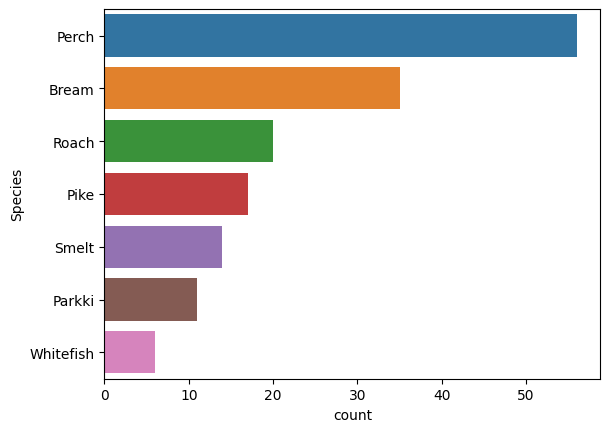

In [135]:
sns.countplot(data = fish_df, y = 'Species', order=spcies_count.index)
plt.show()

# 숫자 타입 변수 탐색

In [136]:
fish_df.describe()

,Weight,Length,Diagonal,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,28.415723,31.227044,8.970994,4.417486
std,357.978317,10.716328,11.610246,4.286208,1.685804
min,0.000000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,63.400000,68.000000,18.957000,8.142000


In [137]:
# 1*5 subplots 생성, 숫자타입 변수 5개 히스토그램

In [138]:
variables = fish_df.columns[1:] # 숫자 타입 컬럼(변수)들의 이름
variables

Index(['Weight', 'Length', 'Diagonal', 'Height', 'Width'], dtype='object')

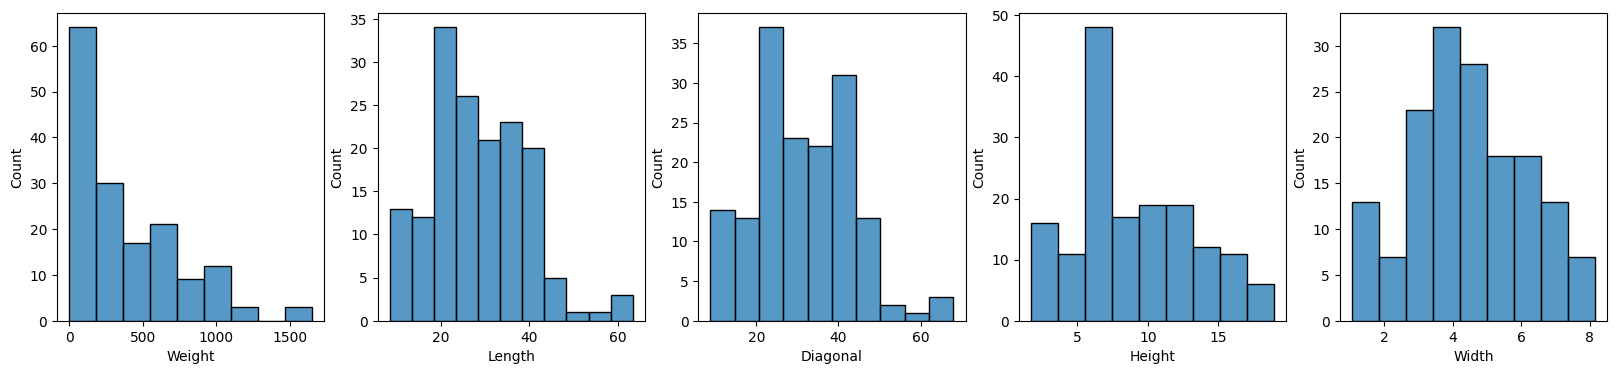

In [139]:
fig, ax = plt.subplots(ncols=5, figsize=(20,4))

for i, v in enumerate(variables):
    sns.histplot(data=fish_df, x=v, ax=ax[i])

plt.show()


In [140]:
# 1*5 subplots 생성, 숫자타입 변수

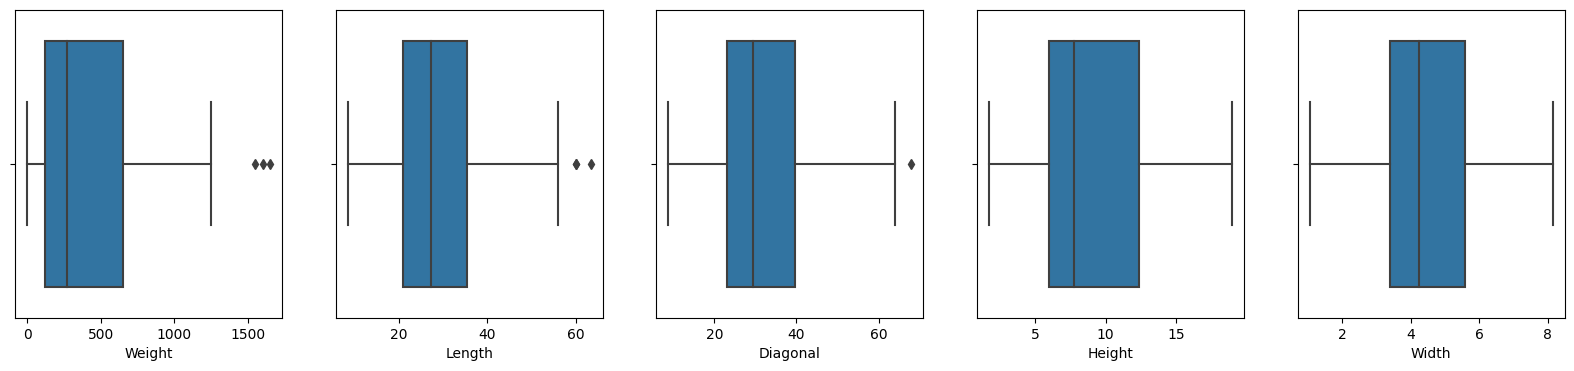

In [141]:
fig, ax = plt.subplots(ncols=5, figsize=(20,4))
for i,v in enumerate(variables):
    sns.boxplot(data=fish_df, x=v, ax=ax[i])
plt.show()

##변수들의 상관관계

In [142]:
fish_df.corr(numeric_only=True) # Pearson 상관계수

,Weight,Length,Diagonal,Height,Width
Weight,1.000000,0.918618,0.923044,0.724345,0.886507
Length,0.918618,1.000000,0.994103,0.640441,0.873547
Diagonal,0.923044,0.994103,1.000000,0.703409,0.878520
Height,0.724345,0.640441,0.703409,1.000000,0.792881
Width,0.886507,0.873547,0.878520,0.792881,1.000000


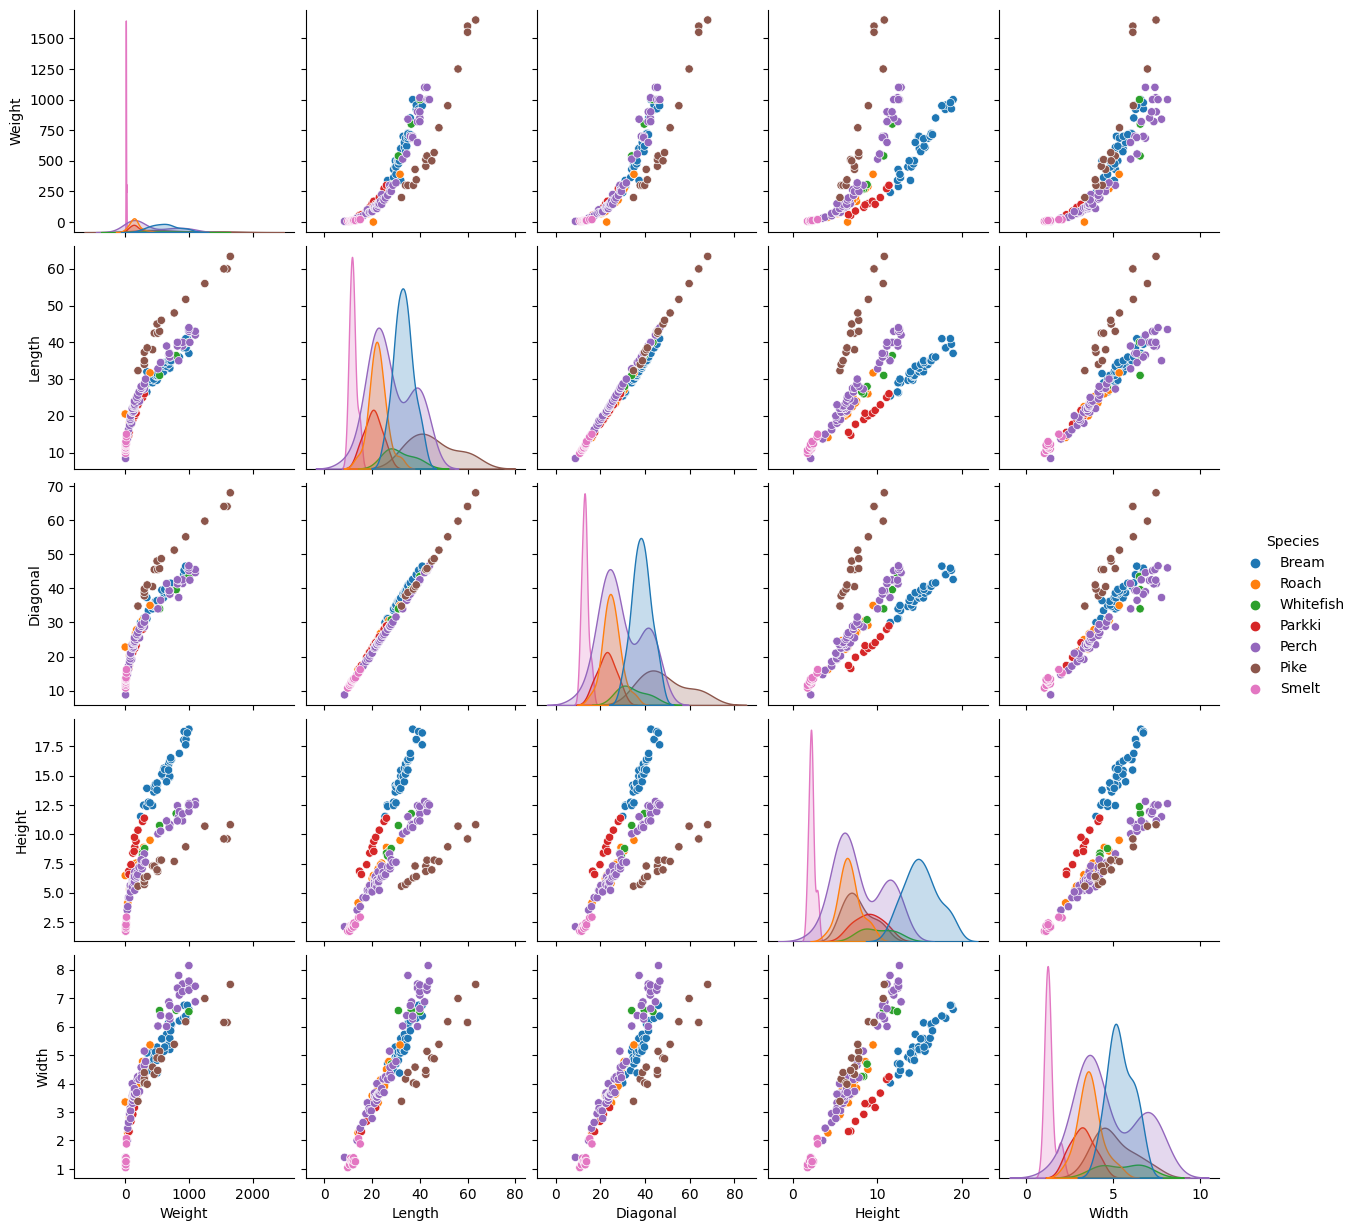

In [143]:
 sns.pairplot(data=fish_df, hue='Species')

# 문제 정의

*  이진 분류(binary classification): Bream(도미), Smelt(빙어) 분류 문제.
*  독립 변수 선택: Weight(무게), Length(길이)

In [144]:
# 머신 러닝에서 사용할 데이터프레임:
df = fish_df[(fish_df.Species == 'Bream') | (fish_df.Species == 'Smelt')][['Species', 'Weight', 'Length']]

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 158
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  49 non-null     object 
 1   Weight   49 non-null     float64
 2   Length   49 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.5+ KB


In [146]:
df.head()

,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5
3,Bream,363.0,29.0
4,Bream,430.0,29.0


In [147]:
df.Species.unique()

array(['Bream', 'Smelt'], dtype=object)

In [148]:
df.Species.value_counts()

Bream    35
Smelt    14
Name: Species, dtype: int64

Weight ~ Length 산점도. Species별로 색깔을 다르게 표현.

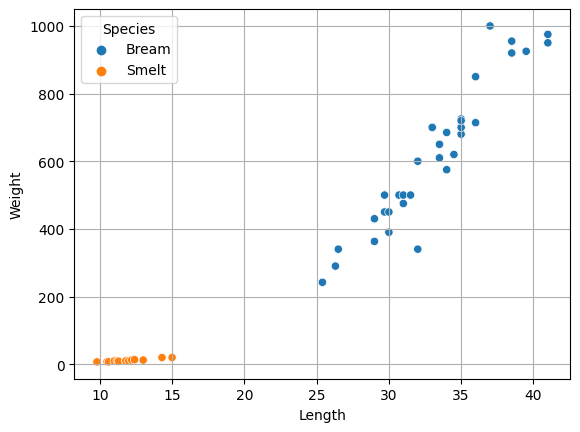

In [149]:
sns.scatterplot(data=df, x='Length', y='Weight', hue='Species')
plt.grid()
plt.show()

*  scikit-learn 패키지는 머신 러닝 알고리즘을 훈련시킬 때, 데이터(특성)와 레이블(타겟)을 구분해서 사용.
*  특성 배열은 2차원 배열. 타겟 배열은 1차원 배열.
*  도미-빙어 2진 분류 문제
    *  특성 배열: 독립 변수들을 원소로 갖는 배열. Weight, Length를 컬럼으로 갖는 2차원 배열
    *  타겟 배열: 레이블을 원소로 갖는 배열. Species만을 갖는 1차원 배열

In [150]:
# 특성 배열의 shape: (n_samples, n_features), (샘플 개수, 특성 개수)
X = df[['Weight', 'Length']].values

# 타겟 배열의 shape: (n_samples,)
y = df['Species'].values

In [151]:
print(X.shape)  # (49, 2)
print(y.shape)  # (49,)

(49, 2)
(49,)


In [152]:
X[:5] # 특성 배열에서 첫 5개 샘플

array([[242. ,  25.4],
       [290. ,  26.3],
       [340. ,  26.5],
       [363. ,  29. ],
       [430. ,  29. ]])

In [153]:
y[:5] # 타겟 배열에서 첫 5개 샘플

array(['Bream', 'Bream', 'Bream', 'Bream', 'Bream'], dtype=object)

In [154]:
X[-5:] # 특성 배열에서 마지막 5개 샘플

array([[12.2, 12.2],
       [13.4, 12.4],
       [12.2, 13. ],
       [19.7, 14.3],
       [19.9, 15. ]])

In [155]:
y[-5:] # 타겟 배열에서 마지막 5개 샘플

array(['Smelt', 'Smelt', 'Smelt', 'Smelt', 'Smelt'], dtype=object)

#머신 러닝 모델 선택

**KNN(K-Nearest Neighbors, k-최근접 이웃)** 분류(classification) 알고리즘

* k개의 가장 가까운 이웃들의 레이블을 사용해서 예측(분류)하는 머신 러닝 모델.
* KNN 모델(알고리즘)은 별고의 훈련(학습) 시간이 필요하지 않음
* KNN은 예측을 할 때 훈련 데이터와 테스트 데이터 사이의 거리들을 계산한 후 가장 가까운 이웃(거리) k를 찾음.
    * 예측 시간이 오래 걸릴 수 있음.
    * 이런 이유로 KNN을 "게으른 알고리즘(lazy algorithm)"이라고 부름

## 머신 러닝 모델 객체 생성

In [156]:
knn = KNeighborsClassifier()
# n_neighbors 파라미터: 기본값 5. KNN 알고리즘에서 사용하라 가장 가까운 이웃 개수.

## 머신 러닝 모델 훈련(train)
데이터를 학습(learn)

In [157]:
knn.fit(X, y)
#> 지도 학습(sujpervised learning): 머신 러닝 모델에게 특성과 레이블을 모두 제공하고 훈련(학습).

KNeighborsClassifier()

## 훈련 셋에서의 학습 결과 평가

In [158]:
y_pred = knn.predict(X)

In [159]:
print(y_pred) # KNN 모델의 예측값 출력

['Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Smelt'
 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt'
 'Smelt' 'Smelt' 'Smelt' 'Smelt']


In [160]:
print(y) # 실제 값

['Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Smelt'
 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt'
 'Smelt' 'Smelt' 'Smelt' 'Smelt']


In [161]:
y==y_pred # 실젯값(타겟)과 예측값이 같은지 비교

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [162]:
np.mean(y==y_pred) # 정확도

1.0

## 가상의 물고기 테스트 데이터의 예측값
(600g, 30cm), (50g, 14cm) 물고기

In [163]:
X_test = np.array([
    [600, 30],
    [50, 14]
])
print(X_test)

[[600  30]
 [ 50  14]]


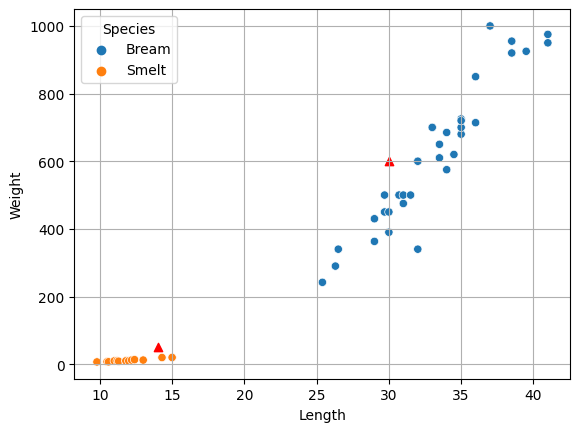

In [164]:
# 훈련 셋 시각화
sns.scatterplot(data=df, x='Length', y='Weight', hue='Species')

# 가상 물고기 테스트 셋(X_test) 시각화
plt.scatter(x=X_test[:, 1], y=X_test[:, 0], c='red', marker='^')

plt.grid()
plt.show()

In [165]:
y_test_pred = knn.predict(X_test)
print(y_test_pred)

['Bream' 'Smelt']


가상 물고기 테스트 셋의 가장 가까운 이웃(nearest neighbors) 찾기

In [166]:
neigh_dist, neigh_ind = knn. kneighbors(X_test)

In [167]:
print(neigh_dist) # 테스트 샘플에서 가장 가까운 거리 k개들의 배열

[[ 2.          2.         10.59481005 20.5        25.3179778 ]
 [30.11660671 30.30148511 36.63495598 37.8132252  37.84283287]]


In [168]:
print(neigh_ind) # 테스트 샘플에서 가장 가까운 이웃 k(=5)개의 인덱스

[[15 14 18 22 20]
 [48 47 45 46 44]]


In [169]:
y[neigh_ind[0]] # (600, 30) 가상 물고기에서 가장 가까운 이웃 5개의 레이블

array(['Bream', 'Bream', 'Bream', 'Bream', 'Bream'], dtype=object)

In [170]:
y[neigh_ind[1]] # (50,14) 가상 물고기에서 가장 가까운 이웃 5개의 레이블

array(['Smelt', 'Smelt', 'Smelt', 'Smelt', 'Smelt'], dtype=object)

#KNN에서 k값에 따른 정확도 변화
* k값(n_neighbors)을 1~ 49까지 변화시키면서 KNN 분류 모델 객체 생성
* 생성된 KNN 모델을 X(특성배열),y(타켓배열)로 훈련.
* 훈련된 모델에서 훈련 셋(X)의 예측값을 계산
* k값에 따른 정확도 그래프(정확도 ~ k)

In [171]:
accuracies=[] # k값의 변화에 따른 KNN 모델의 정확도를 저장하기 위한 리스트
k_values = np.arange(1,50)
for k in k_values:
    knn_clf = KNeighborsClassifier(n_neighbors=k) # KNN 분류기 모델 생성
    knn_clf.fit(X, y) # KNN 모델 훈련(데이터 학습)
    y_pred = knn_clf.predict(X) # 훈련된 모델에서 훈련 셋의 예측값을 계산
    acc = np.mean(y==y_pred) # 예측값의 정확도
    accuracies.append(acc) # 리스트에 정확도를 추가
print(accuracies)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9795918367346939, 1.0, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143]


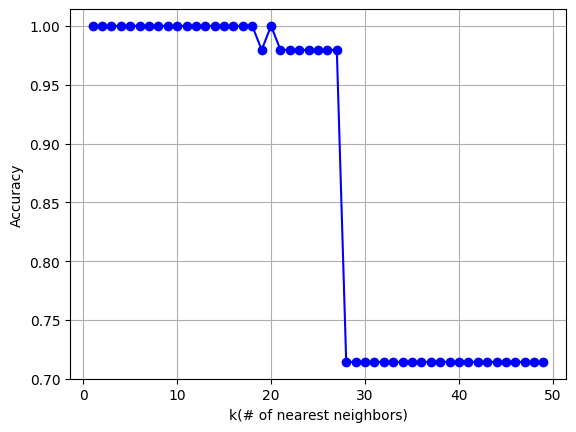

In [172]:
plt.plot(k_values, accuracies, 'bo-')

plt.grid()
plt.xlabel('k(# of nearest neighbors)')
plt.ylabel('Accuracy')

plt.show()

# 훈련 셋, 테스트 셋 분리

훈련 셋과 테스트 셋을 나누는 방법:

* 순차 추출(sequential sampling)
* 임의 추출(random sampling)
* 층화 추출(stratified sampling)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1,
                                                    stratify=y)

`train_test_split()` 함수 파라미터:

*  X, y: 훈련 셋과 테스트 셋으로 나누려고 하는 배열들
*  test_size: 테스트 셋의 샘플 개수 또는 비율.
    *  test_size의 값이 정수이면, 테스트 샘플 개수.
    *  test_size의 값이 0 ~ 1 사이의 실수이면, 테스트 샘플의 비율.
*  train_size: 훈련 셋의 샘플 개수 또는 비율. test_size 값이 있으면 자동으로 계산됨.
*  random_state: 난수를 생성하는 seed(`np.random.seed(숫자)`). 임의 추출 또는 층화 추출에서 샘플들을 섞기 위한 난수를 만들 때 사용.
*  shuffle: 샘플을 랜덤하게 섞을 지를 설정.
    *  True(기본값): 샘플들을 랜덤하게 섞음. 임의 추출.
    *  False: 샘플들을 섞지 않음. 순차 추출.
*  stratify: 층화 추출의 기준이 되는(각 클래스(카테고리)의 비율을 알 수 있는) 1차원 배열. 타겟 배열(레이블).

In [174]:
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((34, 2), (15, 2), (15,), (34,))

In [175]:
pd.value_counts(y_train)

Bream    24
Smelt    10
dtype: int64

In [176]:
pd.value_counts(y_test)

Bream    11
Smelt     4
dtype: int64

## 훈련 셋과 훈련 레이블로 모델 학습

In [177]:
# ML 모델 생성
knn = KNeighborsClassifier()

In [178]:
# ML 모델을 훈련 타겟 배열과 훈련 타겟으로 훈련(학습)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [179]:
# 학습이 끝난 모델에서 훈련 셋의 예측값을 찾고
y_train_pred = knn.predict(X_train)
print(y_train_pred)

['Smelt' 'Bream' 'Smelt' 'Bream' 'Smelt' 'Smelt' 'Bream' 'Smelt' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Smelt' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Smelt' 'Smelt'
 'Bream' 'Smelt' 'Smelt' 'Bream' 'Bream' 'Bream' 'Bream']


In [180]:
np.mean(y_train == y_train_pred) # 훈련 셋에서의 정확도

1.0

In [181]:
# 훈련되지 않은 테스트 셋의 예측값 찾음.
y_test_pred = knn.predict(X_test)
print(y_test_pred)

['Smelt' 'Smelt' 'Smelt' 'Bream' 'Bream' 'Bream' 'Smelt' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream']


In [182]:
# 테스트 셋의 실젯값
print(y_test)

['Smelt' 'Smelt' 'Smelt' 'Bream' 'Bream' 'Bream' 'Smelt' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream']


In [183]:
# 테스트 셋의 정확도
np.mean(y_test == y_test_pred)

1.0

# 분류 평가 지표(metrics)

##오차 행렬, 혼동 행렬(confusion matrix)

In [184]:
# 테스트 셋에서의 실제 레이블(타겟)
y_test

array(['Smelt', 'Smelt', 'Smelt', 'Bream', 'Bream', 'Bream', 'Smelt',
       'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream'], dtype=object)

In [185]:
# 테스트 셋의 예측값
y_test_pred

array(['Smelt', 'Smelt', 'Smelt', 'Bream', 'Bream', 'Bream', 'Smelt',
       'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream'], dtype=object)

In [186]:
confusion_matrix(y_test, y_test_pred)
# 진양성 가음성
# 가양성 진음성

array([[11,  0],
       [ 0,  4]])

In [187]:
cls_report = classification_report(y_test, y_test_pred)
print(cls_report)

              precision    recall  f1-score   support

       Bream       1.00      1.00      1.00        11
       Smelt       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



**분류 평가 지표**
* 용어 정리
    * TP(True Positive, 진짜 양성): 실제 양성 샘플을 양성으로 맞게 예측한 것
    * FP(False Positive, 가짜 양성): 실제 음성 샘플을 양성으로 틀리게 예측한 것
    * TN(True Negetive, 진짜 음성)
    * FN(False Negetive, 가짜 음성)

* **정확도(accuracy)**: 샘플들을 정확하게 분류한 비율. 전체 샘플에서 정답의 비율.
>>> accuracy = (TP + TN) / ( TP + FN + FP + TN )
* **정밀도(precision)**: 양성 예측들 중에서 정답의 비율.
>>> precition = TP /(TP + FP)

* **재현율(recall)**: 실제 양성 샘플들 중에서 정답의 비율.
>>> recall = TP / (TP + FN)

* **F1-score**: 정밀도와 재현율의 조화 평균(역수들의 평균의 역수).
>>> f1_score = 2 / (1/precision + 1/recall)

# 특성 스케일링(Feature Scaling)
변수들의 스케일 변환

In [188]:
X_train[:5]

array([[  8.7,  11.3],
       [500. ,  29.7],
       [  9.9,  11.8],
       [850. ,  36. ],
       [  7. ,  10.6]])

In [189]:
# 가상의 물고기 데이터: (150g, 25cm)
unknown = np.array([[150,25]])

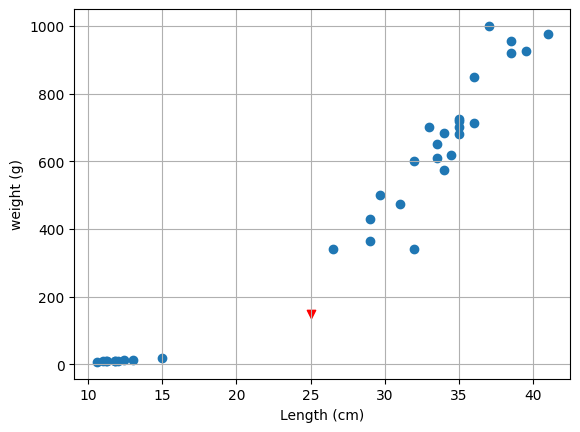

In [191]:
# 훈련 셋(X_train) 시각화
plt.scatter(X_train[:,1], X_train[:,0])

# 가상의 물고기 시각화
plt.scatter(unknown[:,1], unknown[:,0], c='red', marker='v')

plt.xlabel('Length (cm)')
plt.ylabel('weight (g)')
plt.grid()

plt.show()

In [193]:
# Scale 변환을 하지 않은 훈련 셋으로 학습이 끝난 KNN 모델로 예측:
unknown_pred = knn.predict(unknown)
unknown_pred

array(['Smelt'], dtype=object)

In [194]:
neigh_dist, neigh_ind = knn.kneighbors(unknown)

In [195]:
neigh_dist # 가장 가까운 이웃 5개까지의 거리

array([[130.48375378, 137.17988191, 138.32150953, 140.62090883,
        140.72046759]])

In [196]:
neigh_ind # 가장 가까운 이웃 5개의 인덱스

array([[ 7,  5, 15, 26,  2]])

In [197]:
 y_train[neigh_ind] # 가장 가까운 이웃 5개의 어종

array([['Smelt', 'Smelt', 'Smelt', 'Smelt', 'Smelt']], dtype=object)

## 표준화 스케일링

In [200]:
# 표준화 스케일러 객체 생성
scaler = StandardScaler()

# 스케일러를 사용해서 훈련 셋의 스케일을 변환
X_tr_scaled = scaler.fit_transform(X_train)

In [201]:
X_tr_scaled[:5]

array([[-1.36670716, -1.55381172],
       [ 0.07214866,  0.20050088],
       [-1.36319275, -1.50614018],
       [ 1.09718333,  0.80116226],
       [-1.3716859 , -1.62055187]])

In [203]:
# unknown 배열을 스케일 변환:
unknown_scaled = scaler.transform(unknown)

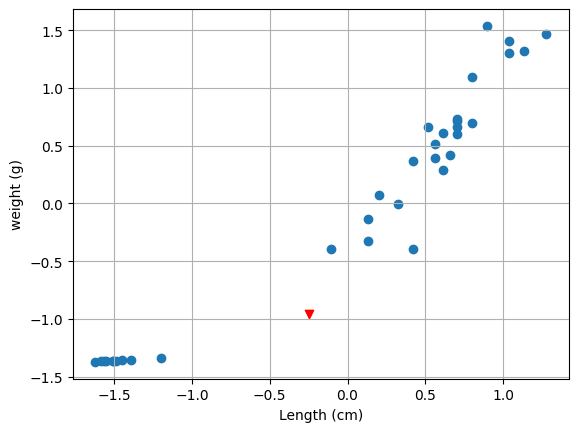

In [204]:
# 스케일 변환된 훈련 셋(X_tr_scaled) 시각화
plt.scatter(X_tr_scaled[:,1], X_tr_scaled[:,0])

# 스케일 변환된 가상의 물고기 시각화
plt.scatter(unknown_scaled[:,1], unknown_scaled[:,0], c='red', marker='v')

plt.xlabel('Length (cm)')
plt.ylabel('weight (g)')
plt.grid()

plt.show()